### Import all the required Python libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os   
import pickle
import pandas as pd
import csv
import cv2

from skimage import exposure, feature, transform
from skimage.color import rgb2gray

# classification required packages

from sklearn.svm import SVC  
from sklearn.model_selection import  train_test_split  #cross_val_score,
from sklearn.metrics import classification_report
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

### Exploratory Analysis

#### The CSV file is loaded into a Pandas dataframe

In [2]:
Datasetimages=pd.read_csv('gicsd_labels.csv', sep = ",", skipinitialspace=True)

In [3]:
Datasetimages.head()

,IMAGE_FILENAME,LABEL
0,GICSD_1_0_3.png,FULL_VISIBILITY
1,GICSD_1_0_13.png,FULL_VISIBILITY
2,GICSD_1_1_33.png,PARTIAL_VISIBILITY
3,GICSD_1_1_53.png,FULL_VISIBILITY
4,GICSD_1_2_73.png,FULL_VISIBILITY


#### In the below cell the image class labels shown in the above dataframe are converted to integers where FULL_VISIBILITY, PARTIAL_VISIBILITY and NO_VISIBILITY strings are replaced by integers 0, 1 and 2.

In [4]:
Datasetimages.LABEL = pd.factorize(Datasetimages.LABEL)[0].astype(np.uint16)

In [5]:
Datasetimages.head()

,IMAGE_FILENAME,LABEL
0,GICSD_1_0_3.png,0
1,GICSD_1_0_13.png,0
2,GICSD_1_1_33.png,1
3,GICSD_1_1_53.png,0
4,GICSD_1_2_73.png,0


In [6]:
print (Datasetimages.dtypes)

IMAGE_FILENAME    object
LABEL             uint16
dtype: object


#### Convert the Dataframe columns into two lists with imagenames and integer labels

In [7]:
filenamelist = Datasetimages['IMAGE_FILENAME'].tolist()
y = Datasetimages['LABEL'].tolist()

In [8]:
# This function is used to visualise class distributions
def class_distribution(y, title):
    n_classes = len(set(y))
    class_count = [0] * n_classes
    for n in y:
        class_count[n] += 1
    class_count_index = [0] * n_classes
    for i in range(n_classes):
        class_count_index[i] = i
    plt.figure(figsize=(6,4))
    plt.bar(range(len(class_count)), class_count)
    plt.xticks(range(len(class_count)), class_count_index)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

In [9]:
newlabelarraydist = [int(numeric_string) for numeric_string in y]

#### It can be clearly seen in the below bar chart that there is a severe class imbalance problem in the image dataset. The NO_VISIBILITY and PARTIAL_VISIBILITY class has  less number of images compared to FULL_VISIBILITY class. The NO_VISIBILITY class has the least number of images.

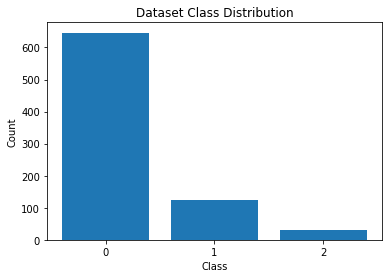

In [10]:
class_distribution(newlabelarraydist, 'Dataset Class Distribution')

In [11]:
FVdf= Datasetimages.where(Datasetimages['LABEL']==0)
PVdf= Datasetimages.where(Datasetimages['LABEL']==1)
NVdf= Datasetimages.where(Datasetimages['LABEL']==2)

#### There are 646 FULL_VISIBILITY category images

In [12]:
FVdf['IMAGE_FILENAME'].count()


646

#### There are 123 PARTIAL_VISIBILITY category images

In [13]:
PVdf['IMAGE_FILENAME'].count()


123

#### There are 31 NO_VISIBILITY category images

In [14]:
NVdf['IMAGE_FILENAME'].count()

31

#### Load the entier image dataset into a list

In [15]:
x=[]
if os.path.isfile("..\\data\\dataset.npy"):
    x = np.load("..\\data\\dataset.npy",allow_pickle=True)
    print("[INFO] Loading images into variable ==> x")
else:
    print("Reading files from raw images")
    for i in range(len(filenamelist)):
        filename=filenamelist[i]
        x.append(plt.imread(os.path.join('..\\data\\images', filename)))
    np.save("..\\data\\dataset.npy",x)
    

[INFO] Loading images into variable ==> x


#### The output of the below cell indicates that the images are of width and height of 192x192 with three dimensions

In [16]:
print(len(x))
print(type(x))
print(type(x[0]))
print((x[1].shape))

800
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(192, 192, 3)


#### An example image from the dataset is shown below. All the images in the dataset are subjected to noise as shown in the below image.

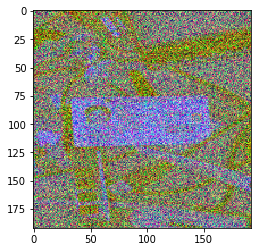

In [17]:
plt.imshow(x[1])

### Class imbalance problem

#### To combat the class imbalance problem in the dataset we use data augmentation technique. Data augmentation is a process during which we create artificial images using the original images in the dataset. We use three different types of augmentation techniques namely translation, scaling and warping of the images. By augmenting the dataset we will make the number of images equal in all the classes. An example translated image is shown as the output of the below cell.

shape in/out: (192, 192, 3) (192, 192, 3)


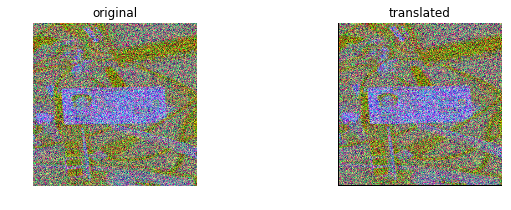

In [18]:
import cv2

def random_translate(img):
    rows,cols,_ = img.shape
    
    # allow translation up to px pixels in x and y directions
    px = 2
    dx,dy = np.random.randint(-px,px,2)

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    #dst = dst[:,:,np.newaxis]
    
    return dst

test_img = x[1]

test_dst = random_translate(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('translated')

print('shape in/out:', test_img.shape, test_dst.shape)

 #### An example scaled augmented image is shown as the output of the below cell.

shape in/out: (192, 192, 3) (192, 192, 3)


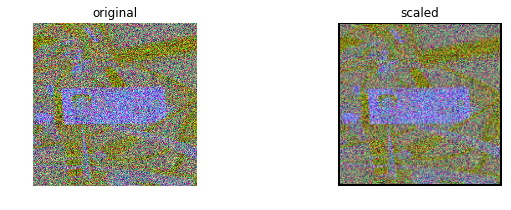

In [19]:
def random_scaling(img):   
    rows,cols,_ = img.shape

    # transform limits
    px = np.random.randint(-2,2)

    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    
    #dst = dst[:,:,np.newaxis]
    
    return dst

test_dst = random_scaling(test_img)
    
fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('scaled')

print('shape in/out:', test_img.shape, test_dst.shape)

 #### An example warped image is shown as the output of the below cell.

shape in/out: (192, 192, 3) (192, 192, 3)


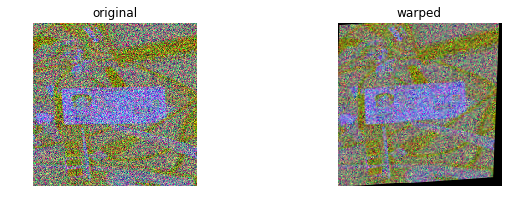

In [20]:
def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   # this coefficient determines the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    
    #dst = dst[:,:,np.newaxis]
    
    return dst

test_dst = random_warp(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('warped')

print('shape in/out:', test_img.shape, test_dst.shape)

#### An example artifical image created by simultaneously scaling, warping and translating the original image

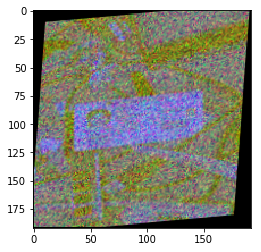

In [21]:
mytestimg= random_translate(random_warp(random_scaling(test_img)))
plt.imshow(mytestimg)

In [22]:
newlabelarray=np.array(y)
training_classes, training_counts = np.unique(newlabelarray, return_counts=True)

#### The Full_VISIBILITY class has 646 images in the dataset. Therefore, we have to augment the other two classes to have 646 images. 

In [23]:
maxSamples = max(training_counts)
nbClasses = len(training_classes)

print("each class of the {} classes should have {} samples".format(len(training_classes), max(training_counts)))

# Calculate the number of images to add for each class to have balanced data
delta = [maxSamples-count for count in training_counts]

each class of the 3 classes should have 646 samples


#### We need to add 523 and 615 artifical images to PARTIAL_VISIBLITY and NO_VISIBILITY classes respectively to balance all the three classes

In [24]:
print(delta)

[0, 523, 615]


In [25]:
# utility function to obtain images by class
def getImagesByClass(X, y, class_id):
    
    '''
    Find the images in X with labels equal to class_id.
    Input:
        X: all the images
        y: all the labels of X
        class_id: the id of class 
    Return:
        x_images: the images of the class with id class_id
        y_images: the labels of x_images
    '''
    newXbyclass=[]
    newYbyclass=[]
    for countimg in range(len(X)):
        if (float(y[countimg])==class_id): 
            newXbyclass.append(X[countimg])
            newYbyclass.append(y[countimg])
    return newXbyclass, newYbyclass

In [26]:
# Funtion to apply scaling, warping and translation simultaneously
def transform_samples(x_samples):
    x_samples_transformed = []
    for img in x_samples:
        x_samples_transformed.append(random_translate(random_warp(random_scaling(img))))
    return x_samples_transformed

In [27]:
X_train_balanced = []
y_train_balanced  = []

#### The actual image augmentation is carried out in the below cell. The output clearly shows how many images were there in the dataset originally and how many more images were added by image augmentation process. After augmentation there will be a total of 1938 images with 646 images per class.

In [28]:
n_classes = len(np.unique(newlabelarray))
for c in range(n_classes):
    x_samples, y_samples = getImagesByClass(x, y, c)
    x_samples_balanced = x_samples
    y_samples_balanced = y_samples
    for i in range(int(maxSamples/len(x_samples))-1):
        x_samples_balanced = np.append(x_samples_balanced, transform_samples(x_samples), axis=0)
        y_samples_balanced = np.append(y_samples_balanced, y_samples, axis=0)

    diff = maxSamples - len(x_samples_balanced)
    if(diff > 0):
        x_samples_balanced = np.append(x_samples_balanced, transform_samples(x_samples[0:diff]), axis=0)
        y_samples_balanced = np.append(y_samples_balanced, y_samples[0:diff], axis=0)
    x_samples_balanced=list(x_samples_balanced)
    y_samples_balanced=list(y_samples_balanced)
    X_train_balanced.append(x_samples_balanced)
    y_train_balanced.append(y_samples_balanced)
    #y_train_balanced=np.append(y_train_balanced,y_samples_balanced, axis=0)
    print("Class {} has {} samples/labels instead of having only {}. {} Samples added.".format(c, len(x_samples_balanced), len(x_samples), delta[c]))

Class 0 has 646 samples/labels instead of having only 646. 0 Samples added.
Class 1 has 646 samples/labels instead of having only 123. 523 Samples added.
Class 2 has 646 samples/labels instead of having only 31. 615 Samples added.


In [29]:
newX = [y for x in X_train_balanced for y in x]
newY=  [y for x in y_train_balanced for y in x]

### Feature engineering

####  In this work for feature engineering a widely used feature extraction method, HOG (Histogram of oriented gradients) is used to extract the features from the images. This is an advanced feature extraction technique compared to using simple grayscale intensities as features. The choice of HOG is made based on the two research papers included in the research papers directory. The papers clearly indicate that HOG can be a useful feature extraction method when the images are noisy. The research paper titles are: 

#### 1) An empirical study on the effects of different types of noise in image classification tasks
#### 2) Analysis of various image feature extraction methods against noisy image: SIFT, SURF and HOG

In [30]:
# utility method to disply HOG image

def showimg_n_hog(grayimg,hogImage):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(grayimg)
    ax1.set_title('Input image')
    ax1.set_adjustable('box-forced')

    ax2.axis('off')
    ax2.imshow(hogImage, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    ax1.set_adjustable('box-forced')
    plt.show()

#### An example image with HOG features is shown below.  The RGB image has to be converted to grayscale image using rgb2gray function in scikitimage library. The HOG features are then extracted from the resized 64x64 grayscale image.

C:\Users\jay.chilukamari\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


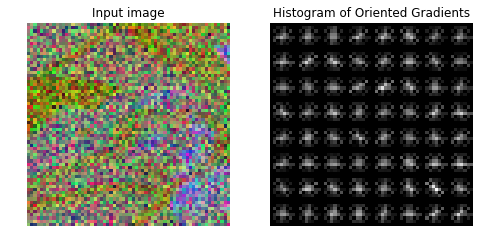

In [31]:
# simple test on single image for HoG features
i1 = newX[1]
grayim = rgb2gray(i1)
gI1 = transform.resize(grayim,(64,64))
(H, hogImage) = feature.hog(gI1, orientations=9, pixels_per_cell=(8,8),
    cells_per_block=(2, 2), transform_sqrt=True, visualize=True)
hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")

showimg_n_hog(i1, hogImage)

#### The HOG features are extracted from all the 1938 images and saved as .npy data format for faster reading speed and reduced storage space.

In [32]:
if os.path.isfile("..\\artifacts\\HoG\\HoGfeatures.npy") & os.path.isfile("..\\artifacts\\HoG\\HoGvisualize.npy") :
    hogfeat = np.load("..\\artifacts\\HoG\\HoGfeatures.npy")
    hogviz = np.load("..\\artifacts\\HoG\\HoGvisualize.npy")  
    print("HoG features are loaded from HoGfeatures.npy to variable ==> hogfeat_test")
    print("HoG visualizations are loaded from HoGvisualize_test.npy to variable ==> hogviz_test")
else:
    print("[INFO] HoGfeatures.npy does not found")
    Hviz = []
    Hfeat = []
    for i in range(0,len(newX)):
        # show an update every 1,000 images
        if i > 0 and i % 200 == 0:
            print("[INFO] processed {}/{}".format(i, len(newX)))
        I = newX[i]
        grayim = rgb2gray(I)
        grayim = transform.resize(grayim,(64,64))
        (H_4x4, hogImage) = feature.hog(grayim, orientations=9, pixels_per_cell=(4, 4),
            cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
        hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")
        Hviz.append(hogImage)
        Hfeat.append(H_4x4)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("..\\artifacts\\HoG\\HoGfeatures.npy", Hfeat)
    np.save("..\\artifacts\\HoG\\HoGvisualize.npy", Hviz)

HoG features are loaded from HoGfeatures.npy to variable ==> hogfeat_test
HoG visualizations are loaded from HoGvisualize_test.npy to variable ==> hogviz_test


#### In the below output it can be seen that there are 1938 images with three classes and each 64x64 image has a feature length of 8100.

In [33]:
Xhog = np.array(hogfeat).astype("float")
newY = np.array(newY).astype("float")
print(Xhog.shape,newY.shape)
print(np.unique(newY))

(1938, 8100) (1938,)
[0. 1. 2.]


In [34]:
Tfeatures=np.transpose(Xhog)

In [35]:
print(Tfeatures.shape)

(8100, 1938)


#### Feature Scaling is a technique to standardize the independent features present in the data in a fixed range. It is performed during the data pre-processing to handle highly varying magnitudes or values or units. The MinMaxScaler of the sklearn package is used to scale the features.

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(Tfeatures)

In [37]:
print(scaled_X.shape)

(8100, 1938)


In [38]:
Tscaled_X=np.transpose(scaled_X)

In [39]:
print(Tscaled_X.shape)

(1938, 8100)


In [40]:
# shuffle the training set
from sklearn.utils import shuffle
features, labels = shuffle(Tscaled_X, newY, random_state=1)

#### Take the  data and construct the training and testing split, using 75% of the data for training and 25% for testing

In [41]:
(trainData, testData, trainLabels, testLabels) = train_test_split(features,
    labels, test_size=0.25, random_state=42)

In [42]:
# show the sizes of each data split
print("training data points: {}".format(len(trainLabels)))
print("testing data points: {}".format(len(testLabels)))

training data points: 1453
testing data points: 485


In [43]:
print(len(trainData))
print(len(testData))

1453
485


#### SVMs are extremely in popular machine learning and are heavily used in computer vision. In fact, the Linear SVMs are frequently used for our custom object detection. Linear SVM's trained on HOG features is now standard practice across many visual perception tasks. The following paper explores the interactions that make HOG-SVM symbiosis performa so well. The paper title is 

#### 1) Why Linear SVMs trained on HOG features perform so well?

#### The HOG features are extracted from the noisy images in the previous cells. A linear SVM is trained on those  HOG features as shown in the below cell. 

In [46]:
if os.path.isfile("..\\artifacts\\svclassifier.pkl"):
    print("[INFO] loading classifier: SVC trained on HoG features...")
    svclassifier = joblib.load("..\\artifacts\\svclassifier.pkl")
    print("[INFO] Classifer is loaded as instance ::svc::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier SVC")
    svclassifier = SVC(kernel='linear')
    svclassifier.fit(trainData,trainLabels)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(svclassifier, "..\\artifacts\\svclassifier.pkl") 
    print("[INFO] Classifier Saved")

[INFO] loading classifier: SVC trained on HoG features...
[INFO] Classifer is loaded as instance ::svc::


#### Classification Accuracy is what we usually mean, when we use the term accuracy. It is the ratio of number of correct predictions to the total number of input samples. It works well only if there are equal number of samples belonging to each class.

In [47]:
print("accuracy on training data: {}".format(svclassifier.score(trainData,trainLabels)))
print("accuracy on testing data: {}".format(svclassifier.score(testData,testLabels)))

accuracy on training data: 1.0
accuracy on testing data: 0.7835051546391752


In [48]:
predictions = svclassifier.predict(testData)

#### Precision and Recall is an important metric to use when there is class imbalance problem. Althought the classes are balanced using image augmentation precision and recall gives a better picture of the classifier performance. Precision, Recall and F1 score is shown for all individual classes below.

In [49]:
# show a final classification report demonstrating the accuracy of the classifier
print("Evaluation on Testing dataset")
print(classification_report(testLabels, predictions)) 

Evaluation on Testing dataset
             precision    recall  f1-score   support

        0.0       0.76      0.94      0.84       157
        1.0       0.75      0.66      0.70       162
        2.0       0.84      0.76      0.80       166

avg / total       0.79      0.78      0.78       485



#### Confusion Matrix as the name suggests gives us a matrix as output and describes the complete performance of the model.  It  is a breakdown of predictions into a table showing correct predictions (the diagonal) and the types of incorrect predictions made (what classes incorrect predictions were assigned). 

Text(0.5,15,'Predicted label')

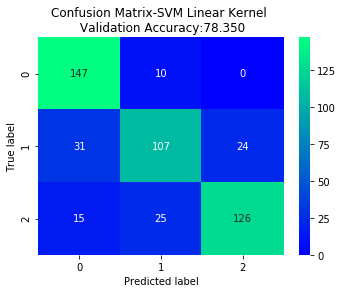

In [51]:
import seaborn as sns
cm=confusion_matrix(testLabels, predictions)
df_cm = pd.DataFrame(cm, 
                     index = [i for i in range(0,3)], columns = [i for i in range(0,3)])

plt.figure(figsize=(5.5,4))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="winter")
plt.title('Confusion Matrix-SVM Linear Kernel \n Validation Accuracy:{0:.3f}'.format(78.35))
plt.ylabel('True label')
plt.xlabel('Predicted label')